# Project Data Preparation - EDA

Name: Edward Chen  
Class: CSCI 349 - Intro to Data Mining  
Semester: Spring 2021  
Instructor: Prof. Brian King

### 1. Problem Statement: COVID-19 Radiography

In this project, we will explore a **clinical Radiography dataset** that contains 21165 Chest X-ray images from multiple medical institutions [1][2]. Each image has a dimension of 299 x 299 pixels (89401 pixels in total). The project's task is to **classify the patients' pneumonia infection** using **Chest X-ray** images. 

The **four possible classifications** for a Chest X-ray image are:
1. **COVID-19 infection**
2. **Non-COVID pneumonia infection** 
3. **Non-COVID pulmonary opacification (lung opacity)**
4. **Normal (non-infected)**


References:  
[1] M.E.H. Chowdhury et al., "Can AI help in screening Viral and COVID-19 pneumonia?" IEEE Access, Vol. 8, 2020, pp. 132665 - 132676.  
[2] Rahman, T. et al., "Exploring the Effect of Image Enhancement Techniques on COVID-19 Detection using Chest X-ray Images."

### 2. Chest X-ray Data: Source, Image Modality, Views, and Typical Spatial features for Symptoms.
The data used in the project are majorly **Posteroanterior (PA view) Chest X-ray images**, which capture the frontal view of patients' lungs. The dataset is sourced from multiple existing publications, public repositories (e.g. GitHub), academic and medical institutions [1].

<figure class="image">
    <img src="https://prod-images-static.radiopaedia.org/images/2089213/f12063879a29e672f675977fabdc89_big_gallery.jpeg" width="300" height="" />
    <figcaption>Fig 1. The PA view of the Chest X-ray image [2]</figcaption>
</figure>

In this project, we will develop tools to classify the patients with pneumonia infection using the spatial features of Chest X-rays images.  
The typical symptoms for **viral pneumonia** include **Ground-Glass Opacification (GGO)** [3], which are shown as diffused misty lung radiopacity in a Chest X-ray. The pulmonary opacification is caused by the decreasing ratio of gas due to displacement by fluid or airway collapse[4]. 

<figure class="image">
    <img src="https://pubs.rsna.org/cms/10.1148/rg.2018170048/asset/images/medium/rg.2018170048.fig2a.gif" width="300" height="" />
    <figcaption>Fig 2. GGO in the Chest X-rays of a pneumonia infected patient. The arrows point to the opacification in the image. [5]</figcaption>
</figure>


References:  
[1] Rahman, T. et al., COVID-19 Radiography Database, [https://www.kaggle.com/tawsifurrahman/covid19-radiography-database](https://www.kaggle.com/tawsifurrahman/covid19-radiography-database)  
[2] Bell, D. et al., Chest radiograph, [https://radiopaedia.org/articles/chest-radiograph](https://radiopaedia.org/articles/chest-radiograph)  
[3] Bell, D. et al., Ground-glass opacification, [https://radiopaedia.org/articles/ground-glass-opacification](https://radiopaedia.org/articles/ground-glass-opacification)  
[4] Knipe, H. et al., Pulmonary opacification, [https://radiopaedia.org/articles/pulmonary-opacification](https://radiopaedia.org/articles/pulmonary-opacification)  
[5] Koo, H. et al., Radiographic and CT features of viral pneumonia, [https://pubs.rsna.org/doi/full/10.1148/rg.2018170048](https://pubs.rsna.org/doi/full/10.1148/rg.2018170048)

### 3. Import the Libraries
The **external libaries** needed for this notebook includes:  
I put the corresponding libary version here in case if you don't have them being installed.
```python
>>> import matplotlib
>>> import seaborn
>>> import numpy
>>> import sklearn
>>> import torch
>>>
>>> print(matplotlib.__version__)
3.2.2
>>> print(seaborn.__version__)
0.10.1
>>> print(numpy.__version__)
1.19.2
>>> print(sklearn.__version__)
0.23.1
>>> print(torch.__version__)
1.5.0
```

In [1]:
import matplotlib
import seaborn
import numpy
import sklearn
import torch

print(matplotlib.__version__)
print(seaborn.__version__)
print(numpy.__version__)
print(sklearn.__version__)
print(torch.__version__)

3.2.2
0.10.1
1.19.1
0.23.2
1.7.0


In [2]:
%matplotlib inline

# matplotlib
import matplotlib.pyplot as plt
from matplotlib.offsetbox import (OffsetImage,
                                  AnnotationBbox,
                                  TextArea)

import seaborn as sns

import numpy as np
import copy

# sklearn
from sklearn.decomposition import PCA

# torch
import torch
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader

# For timing.
import time
tic, toc = (time.time, time.time)

### 4. Creating the DataLoader from the COVID-19 Radiography Dataset
The radiography image data are all in the **Portable Network Graphics (PNG)** format. The PNG images can be directly opened and read by python's **Pillow Image Library** that `pytorch` uses for loading and transforming images.

Therefore, we can use the `torchvision.datasets`'s `ImageFolder` class to load the Chest X-ray images and perform **resizing and grayscale conversion** (from color image to single-channel monochromatic image).

The PNG files insides each subfolder, such as `/COVID/*.png`, of the Radiography dataset are considered to be in the same class by `ImageFolder`. 

We will perform four **transformations** to the image data in the first part of EDA:
1. `transforms.Grayscale()`: Convert color (multi-channel) images to the **monochromatic (single-channel) image**.  
2. `transforms.Resize((256, 256))`: Resize the images' spatial dimension to **256 (width) x 256 (height) in pixels**. The (256, 256) is a typical dimension for the medical images in deep learning analysis (which will be covered in the subsequent cells).  
3. `transforms.ToTensor()`: Convert the **PIL (Pillow) image** object into a **Tensor object** (data type==float). 
4. `transforms.Lambda(lambda x: np.array(x).ravel())`: **Flatten the 2D images** into a 1D array of pixels. The 1D array representation of images will help us in exploring the image's mean, median, and std. The 1D representation will also help us to do **dimensionality reduction**, such as PCA, in the next part of this notebook.

In [3]:
class ImageFolderTargetSpecific(ImageFolder):
    """ Override the __getitem__ method of ImageFolder
        When I pass a tuple (index, class_idx) in indexing the ImageFolder object, 
        the ImageFolder will return a sample at the index from the corresponding 
        class_idx.
    """
    def __getitem__(self, index):
        """
        Args:
            index (int): Index
            index (tuple): (Index, Class_idx)
        Returns:
            tuple: (sample, target) where target is class_index of the target class.
            
            if index is a tuple:
            tuple: (sample, target) where target is class_index of the target class,
            and target == Class_idx == index[1]
        """
        if type(index) is tuple:
            path, target = np.array(self.samples, dtype=object)[np.array(self.targets, dtype=object) == index[1]][index[0]]
        else:
            path, target = self.samples[index]
            
        sample = self.loader(path)
        if self.transform is not None:
            sample = self.transform(sample)
        if self.target_transform is not None:
            target = self.target_transform(target)

        return sample, target
    
# Before flatten, the original shape of the image
# This will be used in reconstructing the flatten image to a 2D image
# using np.reshape(flat_image, shape=ori_image_shape)
ori_image_shape = (256, 256)
flat_xrays = ImageFolderTargetSpecific('../data/COVID-19_Radiography_Dataset/',
                       transform=transforms.Compose([
                           transforms.Grayscale(),
                           transforms.Resize((256, 256)),
                           transforms.ToTensor(),
                           transforms.Lambda(lambda x: np.array(x).ravel())
                       ]))

display(flat_xrays)

Dataset ImageFolderTargetSpecific
    Number of datapoints: 21165
    Root location: ../data/COVID-19_Radiography_Dataset/
    StandardTransform
Transform: Compose(
               Grayscale(num_output_channels=1)
               Resize(size=(256, 256), interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Lambda()
           )

### 5. Number of instances in Four Classes
In the `ImageFolder` that we just created, we can find the correspondence between **class label** (textual label, e.g. "Normal") and **index label** (integer label, e.g. 2) using `ImageFolder.class_to_idx` attribute. 

Furthermore, the `ImageFolder.targets` attribute is an array of integer label for all the images in the datasets. We can use `ImageFolder.targets` to find the number of samples in every target class.

Class to Index correspondence


{'COVID': 0, 'Lung_Opacity': 1, 'Normal': 2, 'Viral Pneumonia': 3}


Classes        : Counts   ratio % of whole Dataset
COVID          :   3616   17.08 %
Lung_Opacity   :   6012   28.41 %
Normal         :  10192   48.15 %
Viral Pneumonia:   1345    6.35 %
Total          :  21165



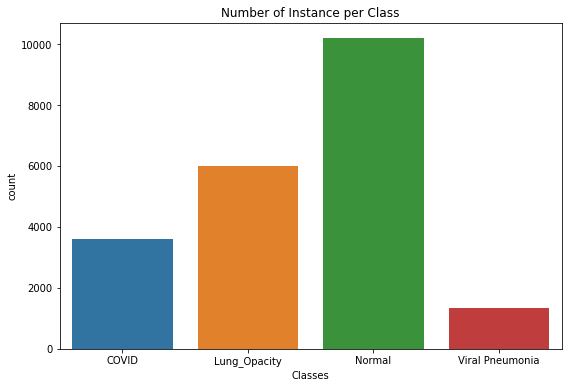

In [4]:
print("Class to Index correspondence")
display(flat_xrays.class_to_idx)
classes, class_counts = np.unique(flat_xrays.targets, return_counts=True)
flat_targets = flat_xrays.targets.copy()

print("\n{:15s}: Counts   ratio % of whole Dataset".format("Classes"))
for i in range(len(flat_xrays.classes)):
    print("{:15s}: {:6d}   {:5.2f} %"
          .format(flat_xrays.classes[i], class_counts[i], 
                  class_counts[i] / np.sum(class_counts) * 100))
print("{:15s}: {:6d}\n".format("Total", np.sum(class_counts)))

fig, ax = plt.subplots(1, figsize=(9, 6))

ax.set_title("Number of Instance per Class")
ax.set_xlabel("Classes")

targets_with_class_name = [flat_xrays.classes[x] for x in flat_targets]
sns.countplot(targets_with_class_name, ax=ax)

plt.show()

### 6. Visualzing one Chest X-ray Sample from the Dataset
To understand the Chest X-ray image data, we will sample out one image sample from the Dataset. We will check the image sample's **minimum and maximum** value (range of pixel values), the **distribution** of pixels value, and its **memory usage**. 

Each image contains **256 x 256 (65536) pixels** value of type `float32`, which is about **256 Kilobytes** (KB) in memory. The memory usage will explode if the whole image dataset (21165 images) is loaded into the memory (about 5 Gigabytes). The `ImageFolder` only store the **paths to the images** and corresponding class label in memory. `ImageFolder` loads image into memory only when users try to access the ImageFolder (e.g. `flat_xrays[0]`). 

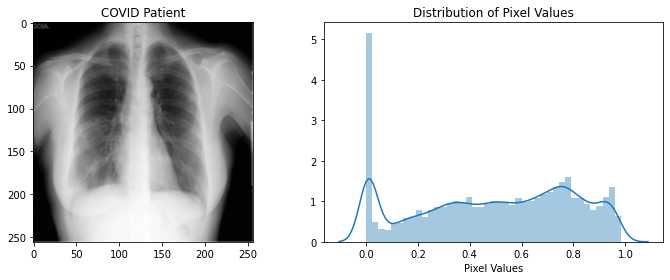

Minimum Pixel Values: 0.000
Maximum Pixel Values: 0.984
Mean Pixel Values: 0.497
Memory Usage: 256.000 KB


In [5]:
np.random.seed(0)
rand_idx = np.random.randint(len(flat_xrays))

sampled_image, target_idx = flat_xrays[rand_idx]
reshaped_image = sampled_image.reshape(ori_image_shape)
class_name = flat_xrays.classes[target_idx]

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].set_title("{:s} Patient".format(class_name))
ax[0].imshow(reshaped_image, cmap='gray')

ax[1].set_title("Distribution of Pixel Values")
sns.distplot(sampled_image, ax=ax[1])
ax[1].set_xlabel("Pixel Values")

plt.tight_layout()
plt.show()

print("Minimum Pixel Values: {:.3f}".format(sampled_image.min()))
print("Maximum Pixel Values: {:.3f}".format(sampled_image.max()))
print("Mean Pixel Values: {:.3f}".format(sampled_image.mean()))
print("Memory Usage: {:.3f} KB".format(sampled_image.nbytes / 1024))

### 7. Sample out 100 Chest X-rays from each Class: 400 Samples in total
As we see in the result of the previous cell, the memory usage of one single image is **256 KB** already. The whole datasets, **21165 images**, will be about **5.17 GB** in total. It will be inefficient and impossible (for typical machines) to load such large dataset into the memory. Therefore, in the subsequent data exploration analysis, we will focus on a **smaller subset** of Radiography datasets.

We will randomly sample **100 of images from each class** to build the subset. The resulting sampled dataset will have **400 samples**/observations.

The reason that Radiography dataset only occupies about 780 Megabytes (MB) on disk is the usage of **PNG compression**. PNG compression is a **lossless compression** that only encodes the predicted errors (**neighboring differences**) of an image [1]. Taking advantage of the **spatial coherence** in images, PNG compression can faithfully reconstruct the original image using only the encoded errors.

We will explore the **Spatial coherence** in the later section as it reveals a way to reduce the image data's dimensionality.

References:  
[1] Roelofs, G., "PNG: The Definitive Guide: Chapter 9. Compression and Filtering", [https://www.oreilly.com/library/view/png-the-definitive/9781565925427/18_chapter-09.html](https://www.oreilly.com/library/view/png-the-definitive/9781565925427/18_chapter-09.html)

In [6]:
num_sample_per_class = 100

sampled_xrays = []
for class_id in range(len(flat_xrays.classes)):
    sampled_xrays.append([np.stack([flat_xrays[i, class_id][0] 
                                    for i in np.random.choice(class_counts[class_id], num_sample_per_class)])])
sampled_xrays = np.array(sampled_xrays)
sampled_xrays = np.squeeze(sampled_xrays, axis=1)

print("The shape of the loaded flatten Chest-X Ray images is: ", sampled_xrays.shape)
print("The Memory usage of 400 samples is {:.3f} MB".format(sampled_xrays.nbytes / (1024 ** 2)))

The shape of the loaded flatten Chest-X Ray images is:  (4, 100, 65536)
The Memory usage of 400 samples is 100.000 MB


### 8. Normalize the intensity range of sampled Chest X-rays using Minmax
To standardize the image data, we apply the **Minmax normalization** on each CXR image. After the normalization, the range of each sampled CXR image will be [0, 1]. The **normalization** of image data **depends on the algorithms** which we will use and **the nature of this dataset** (e.g. if these Chest X-rays produced by a same machine/standard, we can normalize them using the known mean and std of images produced from that machine/standard).

In [7]:
sampled_xrays[..., :] -= sampled_xrays[..., :].min()
sampled_xrays[..., :] /= sampled_xrays[..., :].max()

print("Maximum: ", sampled_xrays.max())
print("Minimum: ", sampled_xrays.min())

Maximum:  1.0
Minimum:  0.0


### 9. The First Challenge of Digital Image Data:
Before we start to explore the statistics of Chest X-Ray (CXR) images, let's acknowledge the **first challenge** we have discovered when working with Digital image data.

**Challenge**: The relatively **large size** of digital image dataset will **inhibit the performance** of machine learning algorithms that have **high space complexity**. For our Radiography dataset, size ~5GB, it is impractical to load the whole dataset and train the machine learning model on it. We need machine learning models that **can be trained incrementally** using smaller subset of Dataset (mini-batch).

Examples of incremental learning algorithms supported by `sklearn` can be found here: [https://scikit-learn.org/0.15/modules/scaling_strategies.html#incremental-learning](https://scikit-learn.org/0.15/modules/scaling_strategies.html#incremental-learning).

### 10. Mean, Median, and STD of the CXR Images
We will compute the **mean, median, and std** of the sampled images in each class. If we treat **each pixel as a variable** for the sample image, there will be 256 x 256 == **65536 variables** in this dataset. Using the conventional methods such as histogram or distribution plot, we **cannot easily visualize the distributions** of such high dimensional dataset.

Moreover, the **values of pixels are meaningful** when we view them in the **context of an image**. A single pixel convey few information, while a group of spatially adjacent pixels will allow us to visualize the meaningful local features of an image.

Thus, we will reconstruct the **mean, median, and std** of all pixels into the **image's original shape** using `np.reshape(flat_image, shape=ori_image_shape)`. We will also plot 3 randomly chosen patients from each class for comparisons.

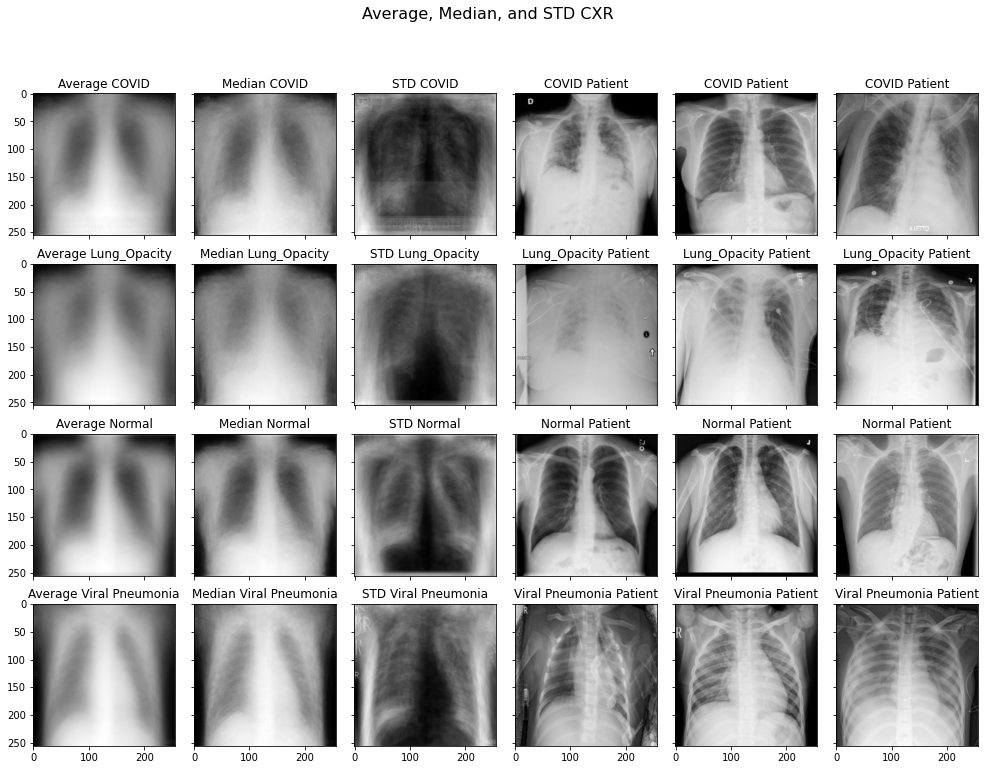

In [8]:
fig, ax = plt.subplots(4,6, figsize=(17, 12), sharey=True, sharex=True)

for class_id in range(len(flat_xrays.classes)):
    target_class = flat_xrays.classes[class_id]
    
    ax[class_id][0].imshow(np.reshape(sampled_xrays[class_id].mean(axis=0), ori_image_shape), cmap='gray')
    ax[class_id][0].set_title('Average {:s}'.format(target_class))
    
    ax[class_id][1].imshow(np.reshape(np.median(sampled_xrays[class_id], axis=0), ori_image_shape), cmap='gray')
    ax[class_id][1].set_title('Median {:s}'.format(target_class))

    ax[class_id][2].imshow(np.reshape(sampled_xrays[class_id].std(axis=0), ori_image_shape), cmap='gray')
    ax[class_id][2].set_title('STD {:s}'.format(target_class))

    selected_pat_indexes = np.random.choice(len(sampled_xrays[class_id]), 3, replace=False)
    for index in range(3):
        patient_index = selected_pat_indexes[index]
        ax[class_id][index + 3].imshow(sampled_xrays[class_id][patient_index].reshape(ori_image_shape), cmap='gray')
        ax[class_id][index + 3].set_title('{:s} Patient'.format(target_class))
    
fig.suptitle("Average, Median, and STD CXR ", fontsize=16)
plt.subplots_adjust(wspace=0.1)
plt.show()

Comparing the Median and Average CXRs from different classes, we can find the typical symptoms of infected lungs. For example, the **airspace of lung** is clear and transparent in the Average CXR of normal patients. 

Compared with the Average CXR of normal patients, the airspace in the Average CXR for **viral pneumonia** is **hazy and diffused**, which are **features of GGO** that we have discussed in the section 2 above.

The Average CXRs of **lung opacity** and **COVID-19** show more **intense pulmonary opacification** (more opaque compared with viral pneumonia), which may be the result of displacement of gas (transparent) by fluid (non-transparent) or airway collapse.

The **standard deviations of CXRs** from different classes **highlight** the **areas with large variation** (in brighter intensity, while the areas with small variation are darker in the plots). As we see on the plots, the areas with **large variations** are usually **around the edges of different structures (lung, rib cage, etc.)**. The other areas have, however, fewer variations across the patients in the same class.

### 11. The Second Challenge of Digital Image Data:
In the cells above, we find the second challenge of digital image data when we try to learn the statistics of image data.

**Challenge**: If we **treat each pixel value as a variable** for the image data, the digital image will have **huge dimensionality** that may inhibit us from learning data's statistics and fail the most of machine learning algorithms.

However, as we observe the **standard deviation of CXRs**, the pixel values do not experience high variation in every area, instead only the areas around the **edges of structures have relatively high variation**. Moreover, the pixel values of spatially adjacent pixels are correlated. This correlation is known as the **spatial coherence of digital images**.

### 12. Spatial Coherence: Neighboring Pixel Values are Correlated
Spatial coherence states that the values among the spatially neighboring pixels have small or no difference. The **values of spatially adjacent pixels have strong correlation**. In this cell, we will plot the **first-order gradient**, difference between neighboring pixels, of a patient's CXR to visualize the spatial coherence. 

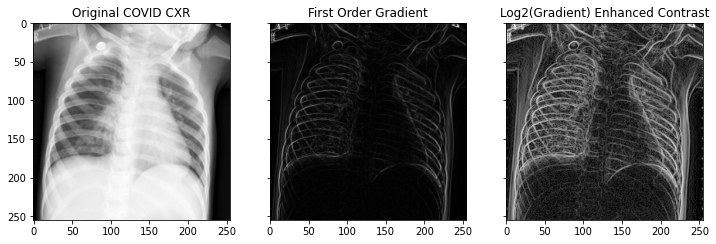

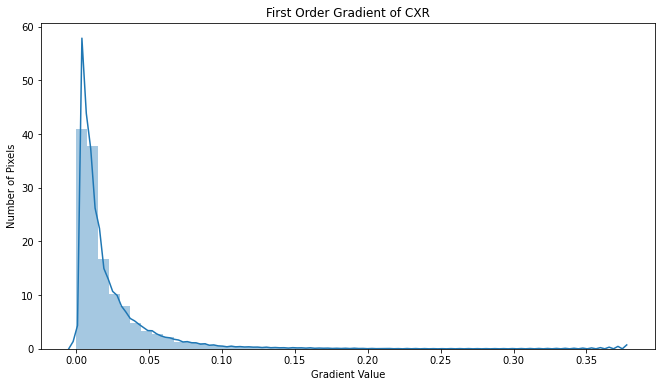

The mean of the Gradient is 0.021
The median of the Gradient is 0.012
The std of the Gradient is 0.027


In [9]:
fig, ax = plt.subplots(1, 3, figsize=(12, 5), sharex=True, sharey=True)

selected_cxr = sampled_xrays[3][70]
selected_cxr_image = selected_cxr.reshape(ori_image_shape)

dx = np.diff(selected_cxr_image, axis=0, n=1)[:, :-1]
dy = np.diff(selected_cxr_image, axis=1, n=1)[:-1, :]

gradient_image = np.sqrt(dx ** 2 + dy ** 2)

ax[0].set_title("Original COVID CXR")
ax[0].imshow(selected_cxr_image, cmap='gray')

ax[1].set_title("First Order Gradient")
ax[1].imshow(gradient_image, cmap='gray')

ax[2].set_title("Log2(Gradient) Enhanced Contrast")
# Apply the Intensity Transformation to Gradient Image
# To better view the gradient map
# See intensity transformation here: https://www.cs.uregina.ca/Links/class-info/425/Lab3/
ax[2].imshow(np.log2(gradient_image + 1e-2), cmap='gray')

plt.show()

fig, ax = plt.subplots(1, figsize = (11, 6))

ax.set_ylabel("Number of Pixels")
ax.set_xlabel("Gradient Value")

ax.set_title("First Order Gradient of CXR")
sns.distplot(gradient_image.ravel(), ax=ax)
plt.show()

print("The mean of the Gradient is {:.3f}".format(gradient_image.mean()))
print("The median of the Gradient is {:.3f}".format(np.median(gradient_image)))
print("The std of the Gradient is {:.3f}".format(gradient_image.std()))

As the histogram of the first-order gradient shows, for an image with intensity range [0, 1], the **difference** between the spatially adjacent pixels **is minimal** (**mean** gradient is **0.021** with **std 0.027**). This is also supported by the plot of gradient images, where the majority of areas have minimal gradients (dark area). The areas with high gradient (brighter area) are usually the edge of objects.

Thus, we find it is **not optimal** to treat each pixel **as an individual variable** since the pixels have **a strong correlation** with their spatial neighbors. In fact, treating pixels as individual variables can be **detrimental** to the machine learning algorithms, such as the Naive Bayes classifier, that assumes the **independence between variables**.

---
Note: On the third plot, **Log2(Gradient) Enhanced Contrast**, I apply an **intensity transformation** to enhance the **contrast** of the image so we can better visualize the image's content. Additional information about intensity transformation can be found here: [https://www.cs.uregina.ca/Links/class-info/425/Lab3/](https://www.cs.uregina.ca/Links/class-info/425/Lab3/).

---

### 13. Dimensionality Reduction: Apply Principal Component Analysis (PCA) to CXR Images
Treating **pixel values as variables** for an image sample, we will have **65536 variables** in total for a sample. 

The **high dimensionality** of image data will inhibit the performance of most machine learning methods, and the **strong correlation between spatially adjacent pixels** will violate the independence assumptions made by some machine learning algorithms. 

To **reduce the dimensionality**, we need a more efficient way to represent the image data. One option is to view each **image sample as a collection of patterns (images)**, which can be found by applying **Principal Component Analysis** (PCA). 

### 14. Create a PCA with 100 Components for our 400 Sampled Patients
In the subsequent cells, we will explore the **optimal number of components** for representing the images in this subset (400 patients). To perform the **PCA** on image data, we need to **flatten the image data**, which we have done in **section 4**. We will apply the **PCA** to the **whole subset** (all classes). Thus, we will reshape our `sampled_xrays` from (4, 100, 65536) to (400, 65536). 

In [10]:
sampled_all_xrays = sampled_xrays.reshape(sampled_xrays.shape[0] * sampled_xrays.shape[1], -1)
sampled_all_targets = (np.ones(shape=(4, 100), dtype=int) * np.arange(4).reshape(4, 1)).reshape(-1).tolist()

pca = PCA(n_components=100)
pca.fit(sampled_all_xrays)

PCA(n_components=100)

### 15. Plot the first 8 Principal Components as Images
Notice that I am using the **1-based index** when numbering the principal components. The `pca.components_` is **sorted** from the **high** explained variance to **low** explained variance.

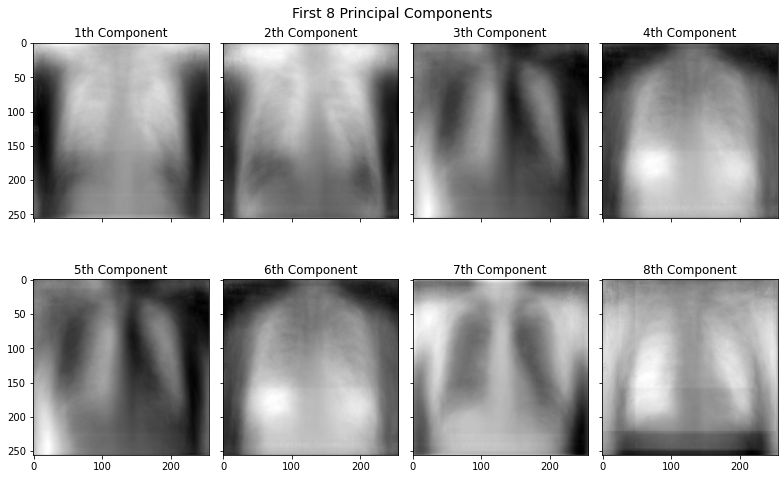

nth Components: Cumulative Variance Ratio
1th Components:             0.270
2th Components:             0.415
3th Components:             0.489
4th Components:             0.556
5th Components:             0.611
6th Components:             0.646
7th Components:             0.676
8th Components:             0.699


In [11]:
fig, ax = plt.subplots(2, 4, figsize=(11, 7), sharex=True, sharey=True)
for row in range(len(ax)):
    for col in range(len(ax[row])):
        ax[row][col].set_title("{:d}th Component".format(row * 4 + col + 1))
        ax[row][col].imshow(pca.components_[row * 2 + col].reshape(ori_image_shape), cmap='gray')
fig.suptitle("First 8 Principal Components", fontsize=14)

plt.tight_layout()
plt.show()

var_ratio = np.cumsum(pca.explained_variance_ratio_)[:8]
print("nth Components: Cumulative Variance Ratio")
for i in range(len(var_ratio)):
    print("{:d}th Components: {:17.3f}".format(i + 1, var_ratio[i]))

We capture **55%** of the variance at the **4th principal components**, and the **first 8** principal components captured about **70% of the variance**.

### 16. Plot the Cumulative Sum of the Variance Ratio at nth Components
To visualize the amount of variance captured at nth components, I plot the **cumulative sum of the variance ratio** at every components. The `pca.explained_variance_ratio_` is sorted from high variance ratio to low variance ratio, and the `pca.components_` is sorted from the high explained variance to low explained variance as well.

The **blue-dotted line** is the plot of **cumulative variance ratio** at nth components.  
The **Red vertical line** marked the point where the principal components captured **> 90%** of variance.  
The **The orange line** show the **explained variance ratio of nth components** (the change in cumulative variance ratio).

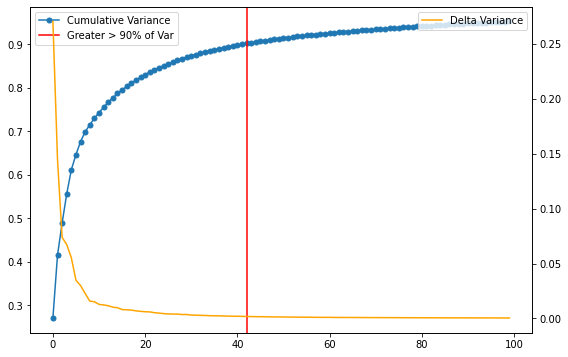

> 90% of Variance:
At 43 th Component, the principal components captured 90.14% of variance


In [12]:
fig, ax = plt.subplots(1, figsize=(9, 6))
cum_variance_ratio = np.cumsum(pca.explained_variance_ratio_)
ninety_var = np.argmax(cum_variance_ratio > 0.9)

ax.plot(cum_variance_ratio, marker='o', markersize=5, label="Cumulative Variance")
ax.axvline(ninety_var, 0, 1, c='r', label="Greater > 90% of Var")
plt.legend()

ax2 = ax.twinx()
ax2.plot(pca.explained_variance_ratio_, color="orange", label="Delta Variance")

plt.legend()
plt.show()

print("> 90% of Variance:")
print("At {:d} th Component, the principal components captured {:.2f}% of variance"
      .format(ninety_var + 1, cum_variance_ratio[ninety_var] * 100))

### 17. Visualize How Images are Separate on the Axis of First 2 Principal Components

First, we sampled out **12 CXRs** from the subset, and transform them using the PCA, `coeff = pca.fit_transform(sampled_all_xrays)`. The first 2 coefficient of principal components, `coeff[plot_cxr, :2]`, will be used as the (x, y) coordinates for the images in the plot below.

#### Sampling 12 CXRs

In [13]:
np.random.seed(30) 
coeff = pca.fit_transform(sampled_all_xrays)
plot_cxr = np.random.choice(len(sampled_all_xrays), 12, replace=False)
xy_pos = coeff[plot_cxr, :2]

#### Plot the samples on the axis of **the first 2 principal components**.

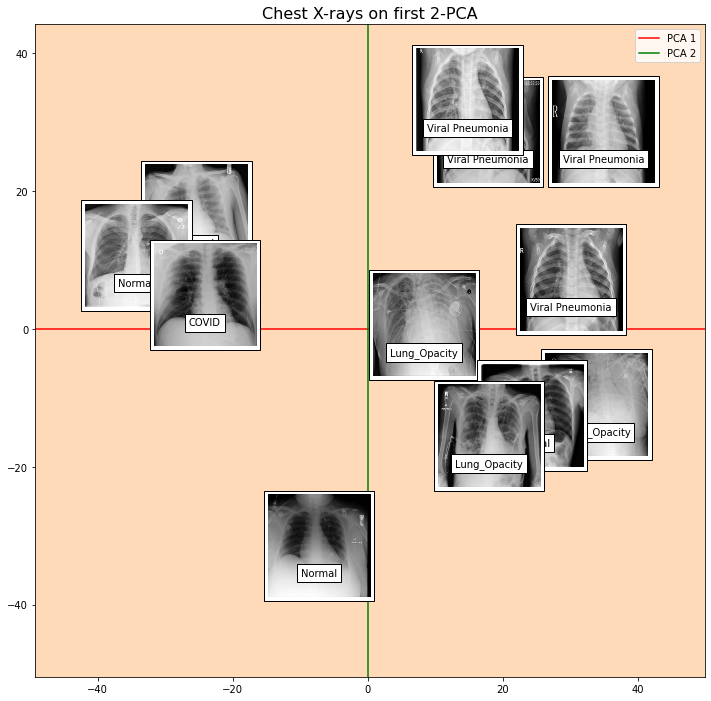

In [14]:
fig, ax2 = plt.subplots(figsize=(12,12))
ax2.set_title('Chest X-rays on first 2-PCA', fontsize=16)
ax2.set_facecolor("peachpuff")

for i, xy in zip(plot_cxr, xy_pos):
    arr_img = np.reshape(sampled_all_xrays[i, :], ori_image_shape)
    target_class_index = sampled_all_targets[i]
    
    # See: https://matplotlib.org/examples/pylab_examples/demo_annotation_box.html
    # For the usage of offset and annotation box
    imagebox = OffsetImage(arr_img, zoom=0.4, cmap='gray')
    imagebox.image.axes = ax2
    
    # xy is 4-d here, just need the first 2 to plot though.
    ab = AnnotationBbox(imagebox, xy + [0, 4])
    
    ax2.add_artist(ab)
    
    textbox = TextArea(flat_xrays.classes[target_class_index])

    ab = AnnotationBbox(textbox, xy)
    
    ax2.add_artist(ab)
    
ax2.axhline(0, 0, 1, label="PCA 1", c="r")
ax2.axvline(0, 0, 1, label="PCA 2", c="g")
    

ax2.set_xlim(xy_pos[:,0].min() - 15, xy_pos[:,0].max() + 15)
ax2.set_ylim(xy_pos[:,1].min() - 15, xy_pos[:,1].max() + 15)

plt.legend()
plt.show()

From the plot above, we can see how well does the CXRs from different classes separate on the first 2 principal components. Remember that **the first 2 principal components** only capture **41.5%** of the variance. If you rerun the sampling and plot cells above several time, you will observe that some CXRs are **not well separate** from the images of different classes. 

Their closeness on the first 2 prinicipal components indicate they have some **similar underlying patterns**. To further separate them, we can introduce **more principal components** into the analysis. 

Yet, the question is: What is the **optimal number of principal components**?

### 18. Optimal Number of Components: Reconstructed a CXR using Principal Components and Coefficients
Another way to visualize the effect of dimensionality reduction by PCA is to compare the difference between the original data and the data reconstructed using principal components. The **difference** between the original data and its projection on the low-dimensional space (space of principal components) is also known as **reconstruction error** (see [slide 10](http://www.cs.cmu.edu/~02317/slides/lec_6.pdf) of this lecture from Carnegie Mellon University). 

We can reconstruct a variable using its **PCA coefficients/scores** with the formula [1] below:

$$ \text{Reconstructed Variable} = \text{PCA Coefficients} \cdot \text{Principal Components} + \mu \text{(Principal Components)}$$ 

Where $\cdot$ means a dot product, and $\text{PCA Coefficients}$, $\text{Principal Components}$, and $\mu$ are vectors.

The **MAE** in the plot belows stands for **Mean absolute error** of pixel values.

Reference:  
[1] amoeba, How to reverse PCA and reconstruct original variables from several principal components?, [https://stats.stackexchange.com/a/229093](https://stats.stackexchange.com/a/229093)

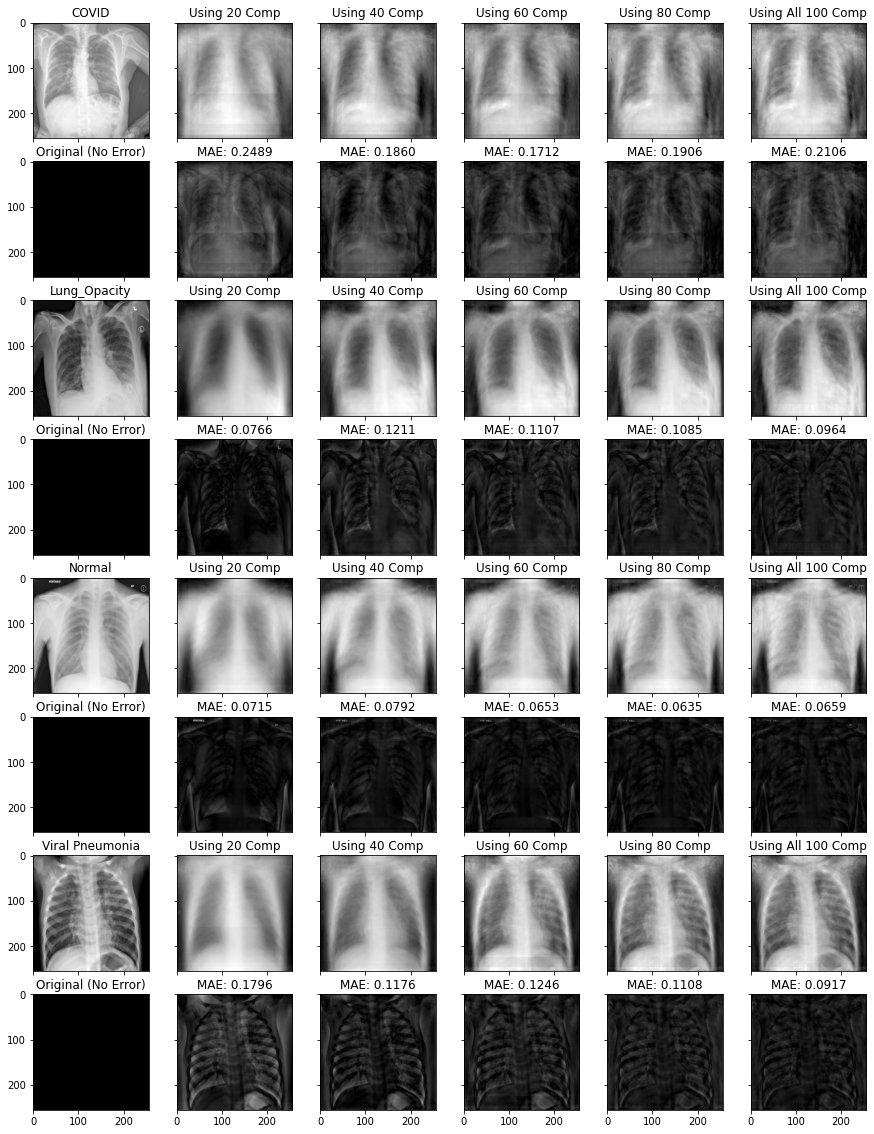

In [15]:
num_patients = 4

pcas = np.concatenate([pca.mean_.reshape(1, -1), pca.components_])

selected_cxrs_indexes = np.random.choice(len(sampled_xrays[0]), num_patients, replace=False)

fig, ax = plt.subplots(num_patients * 2, 6, figsize=(15, 20), sharey=True, sharex=True)

for nth_cxr in range(len(selected_cxrs_indexes)):
    selected_index = selected_cxrs_indexes[nth_cxr]
    selected_cxr = sampled_xrays[nth_cxr][selected_index]
    
    pca_coeff = np.squeeze(pca.transform(selected_cxr.reshape(1, -1)))
    pca_coeff = np.concatenate([[1], pca_coeff])

    ori_cxr = selected_cxr.reshape(ori_image_shape)

    recon_images = [ori_cxr]

    ax[2 * nth_cxr][0].imshow(ori_cxr, cmap='gray')
    ax[2 * nth_cxr][0].set_title("{:s}".format(flat_xrays.classes[nth_cxr]))

    step = 20
    for index, nth_comp in zip(range(6), range(19, pca.n_components + 1, step)):
        image = np.dot(pca_coeff[:nth_comp], pcas[:nth_comp]).reshape(ori_image_shape)
        image -= image.min()
        image /= image.max()
        if (nth_comp + 1) == pca.n_components:
            ax[2 * nth_cxr][index + 1].set_title("Using All {:d} Comp".format(nth_comp+1))
        else:
            ax[2 * nth_cxr][index + 1].set_title("Using {:d} Comp".format(nth_comp+1))
        ax[2 * nth_cxr][index + 1].imshow(image, cmap='gray')
        recon_images.append(image)

    for index in range(len(recon_images)):
        error = abs(ori_cxr - recon_images[index])
        if index == 0:
            ax[2 * nth_cxr + 1][0].set_title("Original (No Error)")
        else:
            ax[2 * nth_cxr + 1][index].set_title("MAE: {:.4f}".format(error.mean()))
        ax[2 * nth_cxr + 1][index].imshow(error, cmap="gray", vmin=0, vmax=1)

plt.show()

As the plot shows, the **Mean Absolute Error (MAE)** decreases as we introduce more principal components into the reconstrution. The details of the reconstructed images become visible when we use keep more principal components.

In the **section 16**, we found that **90% of the variance** is captured when we use the **first 43 principal components**, which is a good reduction in the image data's dimensionality (65536 originally). The number of 43 variables will allow us to apply many machine learning algorithms on the image data.

**However, there are three issues remaining:**  
1. We perform the PCA on a **small subset** (400 patients) of the original datasets (22165 patients). The **number of prinicipal components needed** for the analysis on whole dataset can be **much larger**.  
2. It is **impossible to fit** the whole image dataset (21165 images ~5GB) with PCA **all at once**. We need to **perform the PCA incrementally** using mini-batch of image data. Thankfully, sklearn provides a way to do this: [https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.IncrementalPCA.html](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.IncrementalPCA.html)
3. Finally, it is **harder to interpret the model** using the PCA transformed variables. As we see in the section 15 above, the global patterns of images found by PCA are not intuitive.

Using PCA, we transform the image data into **a linear combination of the global patterns** (principal components) of the dataset. However, when we watch an image, we not only focus on the global patterns. Additionally, we decompose an image into **a collection of specific local features** (e.g. the crying eyes or a similing mouth of a face) and investigate them. Similarly, when clinicians analyze medical images, they are looking for certain symptoms like GGO. **Certain kinds of local features**, such as the hazy lung in the Chest X-Rays, **will be more important** for the analysis than the general patterns among the images.

### 19. Spatial Filter: Local Features of a Digital Image
To extract **local features** from an Image, we can use **filters** (special matrices) to **convolute** across the images.

<figure class="image">
    <img src="https://miro.medium.com/max/654/1*hy15RJHCqT4HzO2VUydjTw.png" width="400" height="" />
    <figcaption>Fig 1. Convolution between an image and a filter matrix. [1]</figcaption>
</figure>

In the cell below, I will show how to use the **sobel x** and **sobel y** filters to extract the **vertical** (changes in x-direction) and **horizontal edges** (changes in y-direction) from a CXR image.

<figure class="image">
    <img src="https://www.projectrhea.org/rhea/images/thumb/9/91/XY_Kernels.png/750px-XY_Kernels.png" width="400" height="" />
    <figcaption>Fig 2. Sobel X and Sobel Y filters (matrices) [2]</figcaption>
</figure>

References:  
[1] Prakash, A., "Machine Learning - Convolution for image processing", [https://blog.francium.tech/machine-learning-convolution-for-image-processing-42623c8dbec0](https://blog.francium.tech/machine-learning-convolution-for-image-processing-42623c8dbec0)  
[2] Sodha, S., "An Implementation of Sobel Edge Detection", [https://www.projectrhea.org/rhea/index.php/An_Implementation_of_Sobel_Edge_Detection](https://www.projectrhea.org/rhea/index.php/An_Implementation_of_Sobel_Edge_Detection)

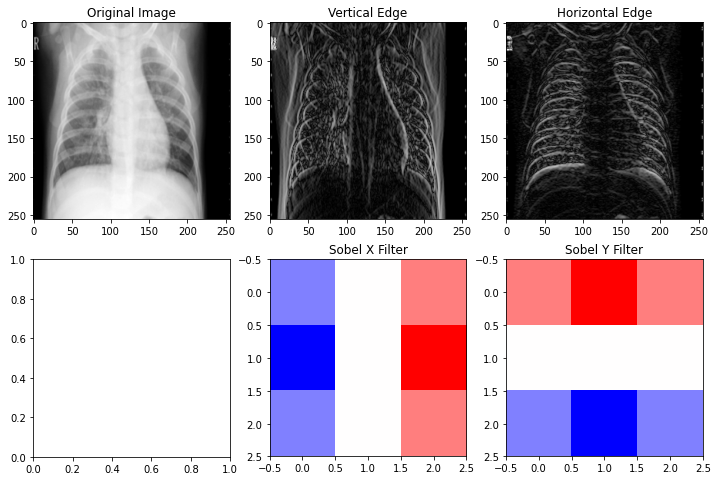

In [16]:
from scipy import ndimage

selected_cxr = sampled_xrays[3][10].reshape(ori_image_shape)
sobel_hor = abs(ndimage.sobel(selected_cxr, axis=0))
sobel_hor_filter = [[1, 2, 1],
                    [0, 0, 0],
                    [-1, -2, -1]]

sobel_ver = abs(ndimage.sobel(selected_cxr, axis=1))
sobel_ver_filter = [[-1, 0, 1],
                    [-2, 0, 2],
                    [-1, 0, 1]]

fig, ax = plt.subplots(2, 3, figsize=(12, 8), )

ax[0][0].set_title("Original Image")
ax[0][0].imshow(selected_cxr, cmap='gray')

# Again, I apply an intensity transformation on the sobel filtered image
# Thus, we can better visualize the image's content with enhanced contrast
ax[0][1].set_title("Vertical Edge")
ax[0][1].imshow(np.log(sobel_ver + 1e-1), cmap='gray')

ax[0][2].set_title("Horizontal Edge")
ax[0][2].imshow(np.log(sobel_hor + 1e-1), cmap='gray')

ax[1][1].set_title("Sobel X Filter")
ax[1][1].imshow(sobel_ver_filter, cmap='bwr')

ax[1][2].set_title("Sobel Y Filter")
ax[1][2].imshow(sobel_hor_filter, cmap='bwr')

plt.show()

The filters that we used above are the fixed/pre-defined filters that extract **a specific kind of feature** from an image (e.g. horizontal lines). However, CXR images certainly have more significant local features which **cannot be extracted by a known/pre-defined filters**. We need a **learnable filter** that can be trained to bias the significant features (e.g. symptoms of viral penumonia). 

To achieve this, one possible solution is to use the **Convolutional Neural Network (CNN)** which I will discuss in the [Modeling notebook](Modeling.ipynb).

### 20. Summary of EDA on Radiography Dataset

The task for COVID-19 Radiography Dataset is to **classify the patients' pneumonia infection** using the **Chest X-ray images**. This classification problem has **four possible targets** for a given Chest X-ray image: (1) COVID-19 infection, (2) Non-COVID viral pneumonia infection, (3) Non-COVID pulmonary opacification (lung opacity), and (4) Normal (non-infected).

We found and discussed **several challenges** of analyzing the digital images above: (1) **High Dimensionality**, (2) Relatively **Large memory usage**, and (3) **strong correlation** among the values of spatially adjacent pixels. 

These challenging features of digital image data undermine the performance of machine learning algorithms that **assumes independence** or **prefers low dimensionality** of variables. The huge memory usage of digital image data may even prevent us from using the machine learning algorithms that **cannot be trained incrementally**.

As mentioned in my discussion in **section 19**, the Convolutional Neural Network, a non-fully connected deep neural network, will be an optimal algorithm for this **classification task**. We will explore which CNN architecures (e.g. ResNet 50) will have the best performance in the [Modeling notebook](Modeling.ipynb).  

**Project Goal:**     
The goal of this project is to build up a **robust deep learning model** that can accurately classify the patient's **infection of penumonia** and the **type of infection** (e.g. COVID-19 or non-COVID viral). The trained Deep Learning Model will be embedded into the computer-aided diagnosis software, which the clinicians can use to accelerate diagnosis.